In [19]:
# Import various packages
from __future__ import division
from sympy import *
import matplotlib.pyplot as plt
import numpy as np
from itertools import repeat
import random as rnd
from scipy import optimize

# Here we import the GA Toolkit (GATO) as GA
import ga_toolkit_v2 as ga

In [15]:
# Read the mock data (based on a fiducial Hubble parameter data, inspired from cosmology)
print('')
print('Now reading the data...')
X,Y,sY=np.loadtxt('./data_hz.txt',usecols=(0,1,2),unpack=True)
ndat=len(X)
print('....')
print('Done!')


Now reading the data...
....
Done!


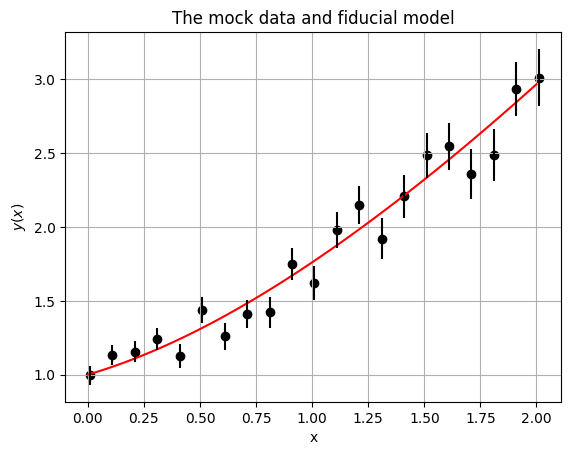

In [16]:
# Plot of the data and the model
Xm = np.linspace(0,2,100)
Ym = np.sqrt(0.3*(1+Xm)**3+0.7)

fig0 = plt.figure(0)
plt.plot(Xm, Ym, 'r')
plt.scatter(X,Y, c='black')
plt.errorbar(X,Y, yerr= sY, ecolor = 'k', ls='none')
plt.title(r'The mock data and fiducial model')
plt.xlabel('x')
plt.ylabel(r'$y(x)$')
plt.grid()
plt.show()

In [17]:
# The mock data chi^2
def chi2_mock(om):
   vecY = np.sqrt(om*(1+X)**3+1-om)
   return np.sum(((Y-vecY)/sY)**2)

In [30]:
# Here we find the best-fit of the mock data to the real model for compararison's sake
# This is a naive example, but it highlights how to use the code etc
minimum = optimize.fmin(chi2_mock, 0.1, full_output=True, disp=True)
print("om_bf = ",minimum[0][0])
print("chi^2_min = ",minimum[1])

Optimization terminated successfully.
         Current function value: 22.611130
         Iterations: 15
         Function evaluations: 30
om_bf =  0.2923437500000007
chi^2_min =  22.611130305949974


In [32]:
# This calculates the chi^2 for the GA
# We also marginalize analytically over a possible offset!
# In this case chi^2_marg=A-B^2/C when y(x)=y_0+GA_prior(x)

def chi2(kid,gram):
	vecy = list(map(ga.make_function,list(X),repeat(kid,ndat),repeat(gram,ndat),repeat(GA_prior,ndat)))
	A = np.sum(((Y-vecy)/sY)**2)
	B = np.sum((Y-vecy)/sY**2)
	C = np.sum(1/sY**2)
	return A-B**2/C

# This calculates the offset
def offset(kid,gram):
	vecy = list(map(ga.make_function,list(X),repeat(kid,ndat),repeat(gram,ndat),repeat(GA_prior,ndat)))
	B = np.sum((Y-vecy)/sY**2)
	C = np.sum(1/sY**2)
	return B/C

In [33]:
# Here you can also specify any physical priors.
# For example, you might need a scaling GA~x for x<<1, then you can say
# GA = x*(1+GAx) etc.

def GA_prior(x, GAx):
	return x*(1.+GAx)

In [34]:
# Here we define the grammar
# More grammars can be added in the ga_toolkit_v2 file

grammar = ['poly', 'polyxtox']

In [36]:
# Different seeds // This is equal to how many chains we need
n_seeds = 3

# Different crossover and mutation rates
# Do a small grid to make sure we sample well the posterior
cross_list = [0.70, 0.75, 0.80]
mut_list = [0.25, 0.30, 0.35]

# Final number of chains
n_chains = n_seeds*len(cross_list)*len(mut_list)

# Here are the input params // Some parameters we change during the actual run, see below
input_params={
'Nchains' : n_chains,
'Ngens' : 100,
'Npops' : 100,
'Nseed' : 1,
'ranges': [[-1,1], [0,len(grammar)], [0, 2], [0, 10]],
'length': 4,
'depth' : 4,
'selectionrate' : 0.3,
'toursize' : 4,
'crossoverrate' : 0.75,
'mutationrate' : 0.3,
'verbose' :  True,
'save_chains' :  [False, 'chain'],
'resume_chains' :  [False, './chains/chain_xxx.pic'],
'grammar' : grammar,
'GA_prior' : 'f(x) = '+str(GA_prior(symbols("x"), symbols("GA")))
}

In [37]:
# Allocate some variables where we store the results
# bfps is the best fit per step // useful for plotting ;-)
run = [0] * input_params['Nchains']
bfps = [0] * input_params['Nchains']
seeds = [0] * input_params['Nchains']

In [38]:
# Here we do the actual runs
# We change some of the params to sample the posterior well, namely the seed, the crossover and mutation rates

ichain = 0
vec = []
for iseed in range(n_seeds):
	input_params['Nseed'] = rnd.randrange(1,100000)
	for cross in range(len(cross_list)):
		input_params['crossoverrate'] = cross_list[cross]
		for mut in range(len(mut_list)):
			input_params['mutationrate'] = mut_list[mut]
			run[ichain] = ga.evolution(chi2, input_params, grammar)
			bfps[ichain] = [row[0] for row in run[ichain]]
			vec.append([input_params['Nseed'],cross,mut])
			ichain +=1
print(vec)


   Genetic Algorithm TOolkit (GATO)

     _.---.._             _.---...__  
  .-'   /\   \          .'  /\     /  
  `.   (  )   \        /   (  )   /   
    `.  \/   .'\      /`.   \/  .'    
      ``---''   )    (   ``---''      
              .';.--.;`.              
            .' /_...._\ `.            
          .'   `.a  a.'   `.          
         (        \/        )         
          `.___..-'`-..___.'          
             \          /             
              `-.____.-'              

Developed by Savvas Nesseris (2022), v2.1.

If you use this code for a publication, please cite:
https://arxiv.org/abs/2203.xxxxx

For more info please see:
https://github.com/snesseris/Genetic-Algorithms

Published under the GPLv3:
https://www.gnu.org/licenses/gpl-3.0.en.html

----------------------------------------


Now running seed 84208
This is generation:  1
This is generation:  2
This is generation:  3
This is generation:  4
This is generation:  5
This is generation:  6
This is ge

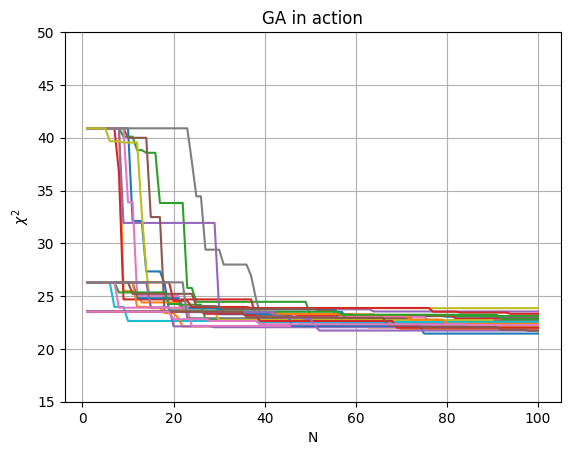

In [46]:
fig1=plt.figure(1)
for ii in range(input_params['Nchains']):
	plt.plot(range(1,input_params['Ngens']+1,1), bfps[ii])
#plt.xscale("log")
#plt.yscale("log")
#plt.legend(loc='upper right')
plt.title(r'GA in action')
plt.xlabel('N')
plt.ylabel(r'$\chi^2$')
ax = plt.gca()
ax.set_ylim([15,50])
plt.grid()
#plt.close(1)

In [41]:
print('The best-fits from the runs are:')
best_fits=[row[-1] for row in bfps]
print(best_fits)
val, idx = min((val, idx) for (idx, val) in enumerate(best_fits))
print('')
print('The overall best-fit from the runs [chi^2, # of run]:')
print([val,idx])

print('')
print('With seed =',seeds[idx])

print('')
print('The best-fit symbolic expression is:')

# This uses sympy to write down a symbolic expression.
xs=symbols("x")
expr=ga.make_function(xs,run[idx][-1][1],grammar,GA_prior)+offset(run[idx][-1][1],grammar)
print('')
print('GA(x) =',expr)

print('')
print('with a chi^2 =',chi2(run[idx][-1][1],grammar))

The best-fits from the runs are:
[23.04416556297292, 22.661873953565646, 23.11994623393639, 22.87077281602751, 23.54664216126912, 21.89872968733698, 22.63493620025656, 22.66575459552314, 23.8604306497798, 22.124046767566142, 22.374529057217842, 21.893688015474254, 22.08842080763452, 23.32395881648199, 22.053285603390577, 22.33345464825561, 22.138580798138264, 22.120562622616944, 22.09529827882625, 22.548852640413315, 21.452815270397878, 22.372028842992222, 22.808294148781442, 22.019200817236197, 21.73993799624168, 21.720675722694523, 22.26779679979518]

The overall best-fit from the runs [chi^2, # of run]:
[21.452815270397878, 20]

With seed = 0

The best-fit symbolic expression is:

GA(x) = x*(0.110629044660176*x - 0.929232898771907*(0.0231903315659521*x)**(0.185522652527617*x) + 0.758552643671651*(0.179361263463905*x)**(1.43489010771124*x) + 1.0) + 1.01839099790805

with a chi^2 = 21.452815270397878


Now plotting the best-fitting function...


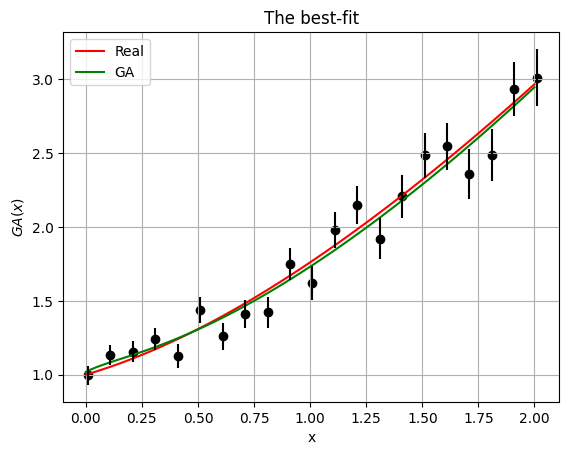

In [48]:
print('Now plotting the best-fitting function...')
Xf = np.linspace(0,2,100)
Yf = list(map(ga.make_function,Xf,repeat(run[idx][-1][1],len(Xf)),repeat(grammar,len(Xf)),repeat(GA_prior,len(Xf))))+offset(run[idx][-1][1],grammar)

# Again the fiducial model
Ym = np.sqrt(0.3*(1+Xf)**3+0.7)

fig2 = plt.figure(2)
plt.plot(Xf, Ym, 'r', label='Real')
plt.plot(Xf, Yf, 'g', label='GA')
plt.scatter(X,Y, c='black')
plt.errorbar(X,Y, yerr= sY, ecolor = 'k', ls='none')
plt.title(r'The best-fit')
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel(r'$GA(x)$')
plt.grid()
plt.show()
fig2.savefig('plot_func.pdf', bbox_inches='tight')
plt.close(2)